In [1]:
import os
import tifffile
import rasterio

import cv2
import numpy as np

import leafmap.leafmap as leafmap
#from samgeo import SamGeo2

import geopandas as gpd
import pickle
from pyproj import Transformer

from utils.raster_tools import Raster_profile 
import matplotlib.pyplot as plt

## Read and find the coverage area of a theos satellite image  

In [2]:
theos_image_file = os.path.join("data/TH2_PATTYA/PANSHAPEN/T2_PRO_ISP202601200442260633_20260120044523273_2/VOL_T2V_ORTHO_DS_T2V_202501190343234_VXB_E101N13_007823_32/IMG_T2V_ORTHO_PMS_32", "IMG_T2V_20250119034323_ORTHO_PMS_32.TIF")
theos_Profile = Raster_profile(theos_image_file) 

Dataset name: data/TH2_PATTYA/PANSHAPEN/T2_PRO_ISP202601200442260633_20260120044523273_2/VOL_T2V_ORTHO_DS_T2V_202501190343234_VXB_E101N13_007823_32/IMG_T2V_ORTHO_PMS_32/IMG_T2V_20250119034323_ORTHO_PMS_32.TIF
File mode: r
Number of bands: 4
Image width: 25832 pixels
Image height: 25360 pixels
Coordinate Reference System (CRS): EPSG:32647
Data shape: (4, 25360, 25832)
Data type: uint16


In [3]:
long_start, lat_start = theos_Profile.get_longlat_from_image_pixels(0, 0, crs_dst="EPSG:4326")

In [4]:
(long_start, lat_start)

(100.86358706151103, 12.965278106840302)

In [5]:
long_end, lat_end = theos_Profile.get_longlat_from_image_pixels(25832, 25360, crs_dst="EPSG:4326")

In [6]:
(long_end, lat_end)

(100.97951520207133, 12.847688902520849)

In [7]:
raster = theos_Profile.raster
raster_HWC = theos_Profile.convert_CHW_to_HWC(raster)
raster_HWC = raster_HWC[:,:,:3]
raster_HWC = theos_Profile.image_enhancement(raster_HWC)


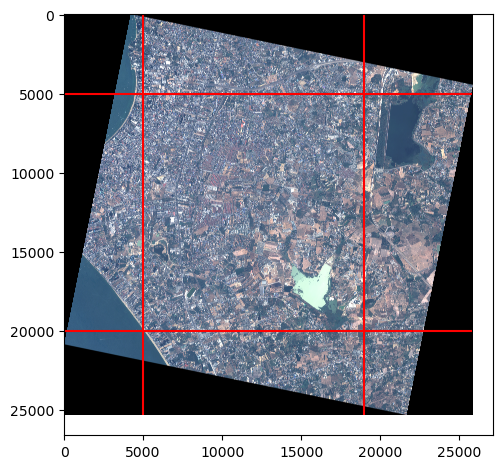

In [10]:
plt.imshow(raster_HWC)
plt.hlines(y=5000, xmin=0, xmax=25832, colors="r") 
plt.hlines(y=20000, xmin=0, xmax=25832, colors="r")
plt.vlines(x=5000, ymin=0, ymax=25360, colors="r") 
plt.vlines(x=19000, ymin=0, ymax=25360, colors="r")  
plt.tight_layout()
plt.savefig("satellite_area_selection.png")

## Select the coordinates

In [11]:
x_start = 5000
y_start = 5000

x_end = 19000
y_end = 20000

bbox = [x_start, y_start, x_end, y_end] 
coordinates = [
    [bbox[0], bbox[3]],  # Top-left corner (min_lon, max_lat)
    [bbox[2], bbox[3]],  # Top-right corner (max_lon, max_lat)
    [bbox[2], bbox[1]],  # Bottom-right corner (max_lon, min_lat)
    [bbox[0], bbox[1]],  # Bottom-left corner (min_lon, min_lat)
    [bbox[0], bbox[3]]   # Closing the polygon by repeating the first point
    ]

poly_gons = []
for coord in coordinates: 
    long, lat = theos_Profile.get_longlat_from_image_pixels(coord[0], coord[1], crs_dst="EPSG:32647")
    poly_gons.append([long, lat])

### Crop image and save tiff

In [12]:
clipped_theos_file = "theos/clipped_IMG_T2V_20250119034323_ORTHO_PMS_32.tif" 
leafmap.clip_image(theos_image_file, poly_gons, clipped_theos_file)

Reading input: /mnt/HDD2/GISTDA_workspace/geo/Building_detection/theos/clipped_IMG_T2V_20250119034323_ORTHO_PMS_32.tif

Adding overviews...
Updating dataset tags...
Writing output to: /mnt/HDD2/GISTDA_workspace/geo/Building_detection/theos/clipped_IMG_T2V_20250119034323_ORTHO_PMS_32.tif


### See the result

In [13]:
clipped_theos_file = "theos/clipped_IMG_T2V_20250119034323_ORTHO_PMS_32.tif"

# m = leafmap.Map(center=[(lat_start + lat_end)/2, (long_start + long_end)/2], zoom=16, height="800px")
m = leafmap.Map(center=[12.908807, 100.922147], zoom=16, height="800px")
m.add_basemap("Satellite") 
m.add_raster(clipped_theos_file, layer_name="Theos") 
m

Map(center=[12.910632, 100.920771], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…